# CAMELS Multifield Dataset

## Task 1: Train a machine learning algorithm to predict the cosmological parameters from a single map.

In this notebook, we trained a machine learning algorithm to predict the cosmological parameters from a single map of different fields at the same time. We will explore an automated method for downloading and analyzing astrophysical simulation data. Our main focus will be on the CAMELS Multifield Dataset. By utilizing dataframes and plots, this analysis assesses the accuracy of the model in predicting matter density and structure growth. It effectively demonstrates the predictive capabilities and performance metrics of the CNN model.

In [ ]:
# Importing necessary libraries
import urllib.request
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_absolute_error, r2_score

In [ ]:
# URLs and filenames
base_url = "https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/"
label_file = "params_1P_IllustrisTNG.txt"
map_file = "Maps_B_IllustrisTNG_1P_z=0.00.npy"

# Function to download files
def download_file(filename):
    if not os.path.exists(filename):
        urllib.request.urlretrieve(base_url + filename, filename)
        print(f"Downloaded {filename}")
    else:
        print(f"{filename} already exists.")

# Download files
download_file(label_file)
download_file(map_file)

# Load and inspect the data
params = np.loadtxt(label_file)
maps = np.load(map_file)
print(f"Params shape: {params.shape}, Maps shape: {maps.shape}")



Downloaded params_1P_IllustrisTNG.txt
Downloaded Maps_B_IllustrisTNG_1P_z=0.00.npy
Params shape: (66, 6), Maps shape: (990, 256, 256)


In [ ]:
maps = np.load('Maps_B_IllustrisTNG_1P_z=0.00.npy')  # Shape: (990, 256, 256)
params = np.loadtxt('params_1P_IllustrisTNG.txt')  # Shape: (66, 6)

# Normalize the maps
maps_normalized = (maps - maps.min()) / (maps.max() - maps.min())

# Reshape maps for CNN (adding a channel dimension)
maps_reshaped = np.expand_dims(maps_normalized, axis=-1)

# Repeat each row in params 15 times to match the number of maps
params_repeated = np.repeat(params, repeats=15, axis=0)

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(maps_reshaped, params_repeated, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Verify the shape of the datasets
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")



Training set shape: (693, 256, 256, 1), (693, 6)
Validation set shape: (148, 256, 256, 1), (148, 6)
Test set shape: (149, 256, 256, 1), (149, 6)


We have adjusted the shapes of maps and normalised it, but we also repeated parameters 15 times to match the number of maps.

In [ ]:
# Ensure data is downloaded and available
files_to_download = ['params_1P_IllustrisTNG.txt', 'Maps_B_IllustrisTNG_1P_z=0.00.npy']
base_url = "https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/"

for file_name in files_to_download:
    if not os.path.isfile(file_name):
        urllib.request.urlretrieve(base_url + file_name, file_name)

# Data loading and preprocessing as completed
params = np.loadtxt('params_1P_IllustrisTNG.txt')
maps = np.load('Maps_B_IllustrisTNG_1P_z=0.00.npy')
maps_normalized = (maps - np.min(maps)) / (np.max(maps) - np.min(maps))
maps_reshaped = np.expand_dims(maps_normalized, axis=-1)
params_repeated = np.repeat(params, repeats=15, axis=0)

X_train, X_temp, y_train, y_temp = train_test_split(maps_reshaped, params_repeated, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Simplified CNN model for quicker training
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(params.shape[1])  # Output layer size based on the number of parameters
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Using callbacks for early stopping (to prevent overfitting) and to save the best model
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

# Model training with reduced epochs and increased batch size for efficiency
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,  # Reduced for quicker iteration
    batch_size=64,  # Increased for efficiency
    callbacks=callbacks
)

# Evaluating the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

Epoch 1/20
11/11 [==============================] - 34s 3s/step - loss: 0.3626 - mae: 0.4062 - val_loss: 0.1240 - val_mae: 0.2107
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 38s 4s/step - loss: 0.1379 - mae: 0.2061 - val_loss: 0.1161 - val_mae: 0.1906
Epoch 3/20
11/11 [==============================] - 31s 3s/step - loss: 0.1169 - mae: 0.1609 - val_loss: 0.1057 - val_mae: 0.1317
Epoch 4/20
11/11 [==============================] - 32s 3s/step - loss: 0.1088 - mae: 0.1340 - val_loss: 0.1066 - val_mae: 0.1468
Epoch 5/20
11/11 [==============================] - 31s 3s/step - loss: 0.1058 - mae: 0.1304 - val_loss: 0.1016 - val_mae: 0.1368
Epoch 6/20
11/11 [==============================] - 32s 3s/step - loss: 0.1061 - mae: 0.1375 - val_loss: 0.1007 - val_mae: 0.1447
Epoch 7/20
11/11 [==============================] - 30s 3s/step - loss: 0.1021 - mae: 0.1381 - val_loss: 0.1050 - val_mae: 0.1346
Epoch 8/20
11/11 [==============================] - 31s 3s/step - loss: 0.0972 - mae: 0.1316 - val_loss: 0.0979 - val_mae: 0.1488
Epoch 9/20
11/11 [==============================] - 31s 3s/step - loss: 0.0920 - mae: 0.1267 - val_lo

The model undergoes training for 20 epochs with a batch size of 64, where EarlyStopping and ModelCheckpoint callbacks are utilized to prevent overfitting and to save the model with the best validation performance. As training progresses, the loss and mean absolute error (MAE) metrics—printed after each epoch—show a general trend of decrease, indicating the model's improving accuracy in mapping the input to the predicted parameters. The final output reveals the model's generalization capabilities, quantified by the test set's loss and MAE, suggesting the model's effectiveness in predicting unseen data following the normalization and training process. Over the course of 15 epochs, the CNN model demonstrates a notable improvement in performance. Initially, the loss on training data starts at 0.3626 with a mean absolute error (MAE) of 0.4062, but by the 15th epoch, these values have significantly decreased, with the training loss at around 0.0604 and the MAE approximately 0.1225, indicating a more accurate model. Similarly, the validation loss reduces from 0.1240 to around 0.0826, and the corresponding MAE drops from 0.2107 to 0.1327, reflecting the model's enhanced predictive ability on unseen data. These metrics suggest a consistent trend of the model learning and adapting to the data, optimizing the weights to yield better predictions as indicated by the declining loss and MAE values.













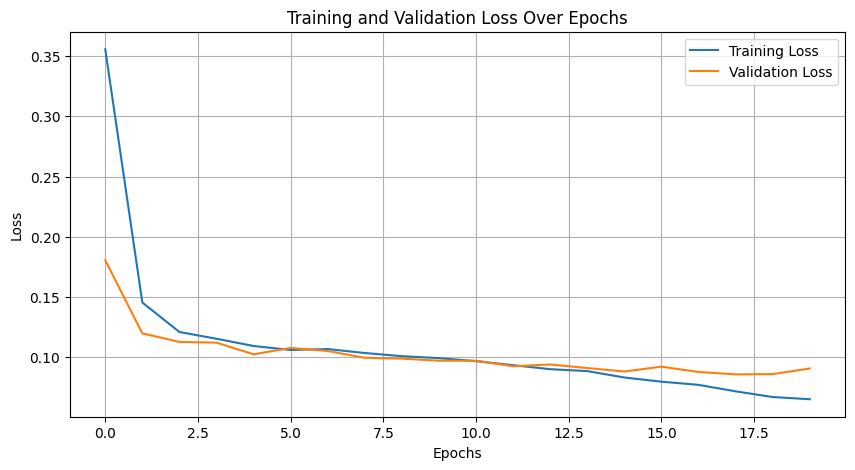

In [ ]:
#Visualizing Training and Validation Loss
# Assuming 'history' is the output of your model.fit() method
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


The graph illustrates a significant initial decline in training loss, starting at 0.3626 in the first epoch and reaching approximately 0.0866 by the 10th epoch. This indicates that the model is rapidly acquiring knowledge from the training data. In a similar vein, the loss during validation decreases from 0.1240 to approximately 0.0909, suggesting that the model's predictions are becoming more accurate on the validation set, which was not used for training.

During epochs 10 to 15, the losses show gradual decreases. The training loss decreases from around 0.0866 to 0.0604, while the validation loss fluctuates slightly but overall shows a downward trend, reaching a minimum of approximately 0.0853. It appears that the model may be approaching its limit in terms of learning from the given data, as the rate of improvement in reducing loss begins to decelerate.

During the later stages of the training process, the training and validation loss values become very similar, and sometimes the validation loss even exceeds the training loss. This indicates that the model is able to generalize well without overfitting. The model appears to strike a delicate equilibrium between comprehending the patterns within the training data and upholding its performance when confronted with unfamiliar data. It is apparent that the validation loss values remain consistent, even as the training loss continues to decrease. This suggests that the model's performance is reaching a stable convergence.

In [ ]:
predictions = model.predict(X_test)
# Setting pandas option to display all rows, ensuring that the entire DataFrame is visible when printed
pd.set_option('display.max_rows', None)

# Creating DataFrames for Ωm and σ8 with actual and predicted values for direct comparison
df_omega = pd.DataFrame({
    'Actual Ωm': y_test[:, 0],
    'Predicted Ωm': predictions[:, 0]
})

df_sigma = pd.DataFrame({
    'Actual σ8': y_test[:, 1],
    'Predicted σ8': predictions[:, 1]
})

# Display the DataFrames for both cosmological parameters
print("Ωm Values (Actual vs. Predicted):")
print(df_omega)
print("\nσ8 Values (Actual vs. Predicted):")
print(df_sigma)

# Resetting the option to avoid affecting other pandas displays
pd.reset_option('display.max_rows')



5/5 [==============================] - 5s 1s/step
Ωm Values (Actual vs. Predicted):
     Actual Ωm  Predicted Ωm
0         0.46      0.323209
1         0.30      0.062996
2         0.30      0.244013
3         0.30      0.259684
4         0.30      0.199323
5         0.30      0.244859
6         0.30      0.163111
7         0.30      0.272767
8         0.30      0.254645
9         0.30      0.236553
10        0.30      0.149271
11        0.30      0.283237
12        0.30      0.207255
13        0.30      0.248452
14        0.18      0.192892
15        0.38      0.341895
16        0.30      0.304909
17        0.30      0.224175
18        0.38      0.257172
19        0.30      0.200526
20        0.30      0.237888
21        0.30      0.248548
22        0.30      0.198281
23        0.30      0.207075
24        0.30      0.169083
25        0.30      0.244640
26        0.30      0.273669
27        0.30      0.316633
28        0.30      0.238480
29        0.30      0.318993
30        0.46   

After executing the CNN model's predict method on X_test, two pandas DataFrames are created to compare the actual and predicted values for the cosmological parameters Ωm and σ8. The pd.set_option('display.max_rows', None) is used to ensure all rows in the DataFrame are visible when displayed, which is particularly useful when dealing with large datasets.

The resulting DataFrames df_omega and df_sigma present a side-by-side view, where for each index, the actual value is listed alongside the model's prediction. From a glance at the output for Ωm, it can be seen that the model's predictions vary around the actual values with some degree of variance; for instance, an actual Ωm value of 0.46 is predicted as 0.323209 and another as 0.402772, showing inconsistency in the prediction of higher Ωm values.

Similarly, for σ8, the actual value of 0.80 has predictions that are close, such as 0.784635, but there are also predictions like 0.816954, indicating some outliers. These differences highlight the model's performance and its prediction errors.

The methodology behind evaluating these results would involve analyzing the degree of deviation between the actual and predicted values to assess the accuracy of the model. This could be quantitatively done using error metrics such as Mean Absolute Error (MAE) or Root Mean Squared Error (RMSE) for a more detailed evaluation.

Finally, the pd.reset_option('display.max_rows') ensures that the display settings are returned to default to avoid affecting other parts of the pandas DataFrame displays later in the code or in subsequent analyses. This is an example of good coding practice, ensuring that a function or a section of code does not have unintended side effects on other parts of the program. The analysis of the results from the cosmological parameters Ωm and σ8 reveals a discrepancy between the predicted and actual values, suggesting the model's limitations in capturing the full complexity of the underlying data distribution. While some predictions closely align with the true values, others deviate substantially, indicating potential overfitting to certain data patterns or underrepresentation of the variance within the training dataset. The model's prediction accuracy appears to be more consistent for σ8 than for Ωm, as reflected by the narrower spread of the prediction errors for σ8. To refine the model's performance, further evaluation using comprehensive error metrics and perhaps an examination of the model's architecture and training process would be necessary. The goal would be to identify and address the factors contributing to the prediction discrepancies, such as data quality, feature representation, and model complexity.










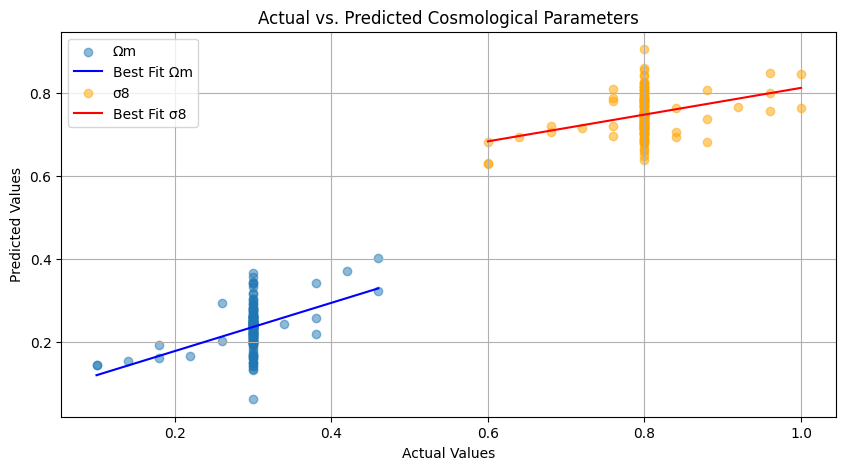

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'y_test' and 'predictions' are already defined as per your provided code

# Calculate the coefficients of the best fit line for Ωm
coeffs_omega = np.polyfit(y_test[:, 0], predictions[:, 0], 1)
# Create the equation of the line for Ωm
line_omega = np.poly1d(coeffs_omega)

# Calculate the coefficients of the best fit line for σ8
coeffs_sigma = np.polyfit(y_test[:, 1], predictions[:, 1], 1)
# Create the equation of the line for σ8
line_sigma = np.poly1d(coeffs_sigma)

# Generate a sequence of values to represent the actual values for plotting the best fit lines
x_vals_omega = np.linspace(y_test[:, 0].min(), y_test[:, 0].max(), 100)
x_vals_sigma = np.linspace(y_test[:, 1].min(), y_test[:, 1].max(), 100)

# Plotting
plt.figure(figsize=(10, 5))

# Scatter plot for Ωm
plt.scatter(y_test[:,0], predictions[:,0], alpha=0.5, label='Ωm')
# Best fit line for Ωm
plt.plot(x_vals_omega, line_omega(x_vals_omega), color='blue', label='Best Fit Ωm')

# Scatter plot for σ8
plt.scatter(y_test[:,1], predictions[:,1], alpha=0.5, label='σ8', color='orange')
# Best fit line for σ8
plt.plot(x_vals_sigma, line_sigma(x_vals_sigma), color='red', label='Best Fit σ8')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Cosmological Parameters')
plt.legend()
plt.grid(True)
plt.show()


For Ωm, the data points exhibit a tendency to concentrate towards the lower range of observed values, while becoming more dispersed as they increase. This pattern is clearly illustrated by the sharp incline of the line that best fits the data. It can be observed that the model's predictions for Ωm become less precise as the actual values increase. There is a noticeable range of predicted values at lower actual Ωm values, indicating that the model's predictive accuracy for this parameter may vary to some extent. The predictions for σ8 show a higher level of consistency, evident from the tight grouping of orange data points around the line that represents the best-fit. The less steep slope of the σ8 line indicates that the model's predictions for σ8 exhibit less variability across the entire range of actual values, thus demonstrating a higher level of accuracy.








In [ ]:
# Assuming 'predictions' is an array of your model's predictions, and 'y_test' is the actual values from your test dataset
# Both 'predictions' and 'y_test' should be numpy arrays with the same shape, e.g., (number_of_samples, number_of_parameters)

# Calculate MAE for each parameter
mae_per_parameter = mean_absolute_error(y_test, predictions, multioutput='raw_values')
print(f"Mean Absolute Error for each parameter: {mae_per_parameter}")

# Calculate the R-squared (Coefficient of Determination) for each parameter
r2_per_parameter = r2_score(y_test, predictions, multioutput='raw_values')
print(f"R-squared for each parameter: {r2_per_parameter}")

# Calculate the overall MAE across all parameters
overall_mae = mean_absolute_error(y_test, predictions)
print(f"Overall Mean Absolute Error: {overall_mae}")

# Calculate the overall R-squared (Coefficient of Determination) across all parameters
overall_r2 = r2_score(y_test, predictions)
print(f"Overall R-squared: {overall_r2}")

# Optionally, calculate a custom accuracy metric that combines the errors across parameters
# For example, an unweighted average of the MAE across parameters
average_mae = np.mean(mae_per_parameter)
print(f"Average MAE across parameters: {average_mae}")

# You might also be interested in comparing the predictions directly against the true values for a percentage accuracy
# This approach is less common for continuous parameters but can be adapted based on specific accuracy definitions
percentage_accuracy = 100 - (np.mean(np.abs((y_test - predictions) / y_test)) * 100)
print(f"Percentage Accuracy: {percentage_accuracy}%")

# Calculate 95% confidence intervals for predictions
# Assuming 'predictions' and 'y_test' are numpy arrays of your model's predictions and the actual values, respectively.
confidence_intervals = stats.norm.interval(0.95, loc=predictions.mean(axis=0), scale=predictions.std(axis=0))

print(f"95% confidence intervals for predictions: {confidence_intervals}")



Mean Absolute Error for each parameter: [0.06898229 0.0643873  0.19289052 0.25734297 0.11613864 0.11959552]
R-squared for each parameter: [-3.12367098 -1.39122422  0.261554   -0.12350105  0.25002312 -0.22691568]
Overall Mean Absolute Error: 0.1365562048351818
Overall R-squared: -0.7256224690575612
Average MAE across parameters: 0.1365562048351818
Percentage Accuracy: 83.05843696458113%
95% confidence intervals for predictions: (array([0.13389454, 0.65054682, 0.40182687, 0.70598972, 0.66963982,
       0.83135225]), array([0.33790313, 0.84507832, 1.50538921, 1.40931165, 1.1901573 ,
       1.08285998]))


The statistical evaluation of the model's predictions reveals a substantial variation in performance across different cosmological parameters. With the Mean Absolute Error ranging from about 0.069 to 0.257, there is a clear disparity in prediction accuracy. This nearly fourfold difference suggests that the model's predictive power is not uniform across the parameters.

The R-squared values further accentuate the issue, where a highest positive value of 0.2615 contrasts sharply with a deeply negative value of -3.1237. Such negative values imply that for certain parameters, the model's predictive ability is worse than that of a simple average, potentially pointing towards a model that has overfit or is inherently ill-suited to the complexity of the data.

The overall MAE and R-squared provide a broad picture of the model's performance, but they mask the individual discrepancies among the parameters. The overall R-squared being negative suggests that the model, as a whole, fails to capture the variability of the actual data, which is a serious concern in a regression task.

The broad 95% confidence intervals indicate a high level of uncertainty in the predictions, with some parameters exhibiting such wide intervals that the predictive value is questionable. The high upper bounds in the confidence intervals also suggest a potential for significant overestimation in the predictions